In [209]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import utils as ut

# Model of the ant colony
system_name = 'ant_cons2_stress'
# Name of the specific run with the current parmeters
run_name = '4p_stress_INIT_RAND_SymplClip'
data_dir = 'data/' + system_name + '/' + run_name + '/'

## Environment

### General parameters

In [210]:
env_params = dict()

# Size of the belly of each ant
env_params['max_k'] = 10
# Number of recipient in the colony
env_params['n_recipients'] = 3
# Probability of a succesfull gathering
env_params['p_succ'] = 0.05

if system_name == 'ant_cons' or system_name == 'ant_cons2' or system_name == 'ant_cons2_fast' or system_name == 'ant_cons2_death' or system_name == 'ant_cons2_stress':
    # Probability that the food of a recipient decreases
    env_params['p_consume'] = 0.033333
if system_name == 'ant_cons2_death':
    # Penalty for death
    env_params['pen_death'] = 10
    env_params['rew_eat'] = 0
    env_params['true_gamma'] = 0.999
    env_params['reward_life'] = 'true'
if system_name == 'ant_cons2_stress':
    # Penalty for stress
    env_params['pen_stress'] = 0.1
    env_params['reward_life'] = 'false'
    env_params['rew_eat'] = 0

### Initial condition

In [211]:
# Number between 1-max_k for a deterministic initialization of the ant food
# Number greater than max_k for a random initialization
env_params['init_k'] = [env_params['max_k'] for _ in range(env_params['n_recipients']+1)]
#env_params['init_k'] = [3 for _ in range(env_params['n_recipients']+1)]

## Algorithm

### Algorithm type

In [212]:
alg_params = dict()
alg_params['alg_type'] = 'nac'
alg_params['gamma'] = 1.000
alg_params['stop_by_discount'] = 'false'
alg_params['lambda_actor'] = 0.95
alg_params['lambda_critic'] = 0.95
alg_params['continuous_task'] = 'true'
alg_params['lr_rew_factor'] = 1
alg_params['simplex_clipping'] = 'true'
alg_params['simplex_clipping_epsilon'] = 0.00001

# TIME
alg_params['n_steps'] = 5000000 # Number of training steps
alg_params['traj_points'] = 500

# EVALUATION
alg_params['eval_steps'] = 100000 # Number of evaluation steps at the end of the training

### General parameters

In [213]:
# CRITIC LEARNING RATE
alg_params['a0'] = 0.001
alg_params['ac'] = alg_params['n_steps'] / 600
alg_params['a_expn'] = 0.75
alg_params['a_burn'] = alg_params['n_steps']
# List of multiplicative factors for the actor learnig rates for each player
alg_params['a_lr_factor'] = np.ones(env_params['n_recipients']+1)
alg_params['a_lr_factor'][0] = 1/env_params['n_recipients']



# ACTOR LEARNING RATE
alg_params['b0'] = 0.0001
alg_params['bc'] = alg_params['n_steps'] / 500
alg_params['b_expn'] = 0.8
alg_params['b_burn'] = alg_params['n_steps']  
# List of multiplicative factors for the actor learnig rates for each player
alg_params['b_lr_factor'] = np.ones(env_params['n_recipients']+1)
alg_params['b_lr_factor'][0] = 1/env_params['n_recipients']

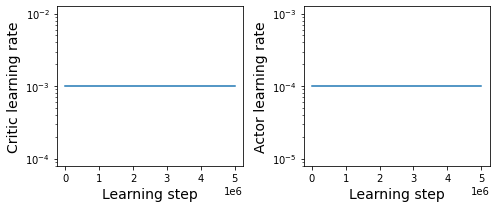

In [214]:
fig, (ax1, ax2) = ut.plot_lr(alg_params)
plt.tight_layout()

### Init condition of the learning

In [215]:
# INITIAL CONDITIONS
# Comment 'init_q_path' for a flat policy
alg_params['init_values'] = 0
#alg_params['init_values_rand'] = 150

In [216]:
#alg_params['init_val_path'] = data_dir + '/init_val.txt' 
#forag_val = 25
#rec_val = forag_valdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAfAAAADQCAYAAAD4dzNkAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8vihELAAAACXBIWXMAAAsTAAALEwEAmpwYAAA0LUlEQVR4nO3dd3hUZdrH8e+dBkkgoZNASCihdwiIomJBxYJYEHtblbW71V1f3dV113WtuxZsawEbiujawHVdFSu9QwAJPYTeSYC0+/3jTGQ2pkySmTlT7s91zcXknJnJLxOe3HPOeYqoKsYYY4wJLzFuBzDGGGNM3VkBN8YYY8KQFXBjjDEmDFkBN8YYY8KQFXBjjDEmDMW5HSAYWrVqpR07dnQ7hjEBNX/+/J2q2trtHMFkbdtEg+radlQU8I4dOzJv3jy3YxgTUCKywe0MwWZt20SD6tq2nUI3xhhjwpAVcGOMMSYMRcUpdGNM6BORGODPQAowT1UnuRzJmJBmR+DGmAYTkZdFZLuILKu0fZSIrBKRPBH5fS0vMwZoD5QA+YHKakykiPoj8KLiUvYfKnU7RkDFCLRu2ggRcTuKiVwTgaeBVys2iEgsMAE4DacgzxWRD4FY4MFKz/8Z0B2YqarPi8hU4POGBNp58AilZZG91kNyo1iaNo53O4ZxSdQX8I+XbOHOqUvcjhFw943uxTXDO7kdw0QoVf1aRDpW2jwUyFPVtQAi8hYwRlUfBM6p/Boikg8Ue74sa2im6ybOZXH+voa+TEhLjI9l9t2nkmJFPCpFdAEXkdHA6Ozs7GofMzirOQ9e0Dd4oVzw549zWbez0O0YJvq0BzZ5fZ0PHFPD498DnhKRE4Cvq3uQiIwHxgNkZmZW+2I3n5zN7sLiaveHu6Wb9/Hm7I1s23fYCniUiugCrqofAR/l5OTcUN1jurRuQpfWTYKYKviemZHHvkMlbscw0aeqazbVntNW1SLgutpeVFVfAF4AyMnJqfb1zuid5kPE8NXuhx28OXujte0oZp3YokCzxARr5MYN+UAHr68zgAKXskScZonOUbe17ehlBTwKpCbGs9cauQm+uUBXEekkIgnAJcCHLmeKGKmeAr63yNp2tLICHgVSk+LtU7oJKBGZDMwEuotIvohcp6qlwK3Ap8AKYIqqLnczZyRplmRH4NEuoq+BG0dqYjz7rZGbAFLVS6vZPh2Y7u/v50sH1UhXMXzMCnj0siPwKJCaGM/eohJUI3tMrIkeqvqRqo5PTU11O4prYmOEpo3jrIBHMSvgUaBZYjyl5UpRcYOH1hpjQkgzuzwW1ayAR4EfO7tYQzcmojhn1yJ3rLupmc8FXET6isjTIvKJiKR7tp0nIgMDF8/4Q0UB32e9VU0VRORMEflYRHJFpINn2/Uicqrb2UzNUhPtCDya+VTAReR0nCEh7YFTgETPri7AvYGJ1nAiMlpEXti3L7KnU6xNqvVWNdUQkcuBKcBqoBNQMaVXLHCnW7lqY23bYXM8RDdfj8D/DPxKVc/n6FzFADNw5jsOSdbRxfHjEfghO9VmfuJO4AZV/SXgvarPLGCAK4l8YG3bkWJH4FHN1wLem6qHguwGWvgvjgmEZkkJgB2Bmyp1xRm/XdlBnHW5TQir6MRmI0yik68FfA/O6fPKBmHr9oa8VJty0VSvAOhWxfYTgTVBzmLqKDUxnpIy5VCJjTCJRr4W8DeBR0QkA2cxgjgRGQE8itf6vyY0JSfEEhsjNuWiqcoLwJMiMtzzdQcRuRp4GHjWvVjGFzadanTzdSa2e4CJwAacFYZyPf++CTwQkGTGb0SEZnatzFRBVR8WkVTgM6Ax8CVwBHhUVSe4Gs7UyntBk3bNEmt5tIk0PhVwVS0BLheRP+CcNo8BFqrq6kCGM/5jw01MdVT1bhF5AOiF07ZzVfWgy7GMD+zyWHTzdRjZH0UkSVXXqupUVZ2iqqtFJFFE/hjokKbhrLeqqYqIvCwiTVW1SFXnqeocVT0oIski8rLb+apjw8gcKXYKPar5eg38XqBJFduTCOFx4OYom3LRVONqjs7r4C0RuCrIWXxmw8gcFSuS2WJF0cnXa+CC03mtsoE4Q8lMiEtNjGftjkK3Y5gQISItcNq1AM1FxHsMeCxwNrDNjWzGd0enSbY5HqJRjQVcRA7gFG4F1oqIdxGPxen08lzg4hl/sU5sppKdHG3buVXsV+zsWshr0iiO2Bixth2lajsCvxXnE/rLwN2A9wWnYmC9qlY1CYQJMamJ8ew/XEJ5uRITI27HMe47GadtfwFcyP+eSSsGNqhqgRvBjO9ExDqoRrEaC7iqTgIQkXXA957e6CYMpSTGowoHDpf+ODe6iV6q+hWAiHQCNqlqucuRTD05K5LZn+Zo5Oswsq8q7otIGpBQaf9GP+cyfuY9naoVcFNBVTcAiEg7IJOftu2v3chlfGdH4NHLpwIuIinAU8A4KjVwj1h/hvIXERkNjM7OznY7iuu8O7tkkuRyGhMqPIX7TZypU5Wfdli1th3iUhPj2WNrgkclX4eRPQb0B84DDgOXAb/FmQf94oAk8wMbanJUempjAAr2HnI5iQkx/wDKcCZxKQJOAC4CVgCj3ItVM2vbR6WnNrZ2HaV8HUZ2JnCpqn4jImXAfFV9W0S2AD8HpgYsofGLDi2co+6Nu4tcTmJCzAjgbFVd6RllskNVvxORIzjLCH/mbjxTmw4tkth5sJjCI6UkN/L1T7qJBL4egTfDmQcdnJ7oLT33ZwLH+TmTCYDUxHiaJcWzYZcVcPM/EnGGlIHTE72N534u0M+VRKZOslrah/No5WsBXwN09txfAVwiIgJcgE3kEjYyWyRZIzeVrQR6eO4vAm4UkSzgFmCzW6GM7zLt7FrU8vV8y0ScT+MzgL8BH+OMEY8B7ghEMON/mS2SWLo5uueONj/xBJDmuX8/8G/gUpwVya52K5TxXVaLZAA22tm1qOPrMLK/e93/QkR6ADnAalVdGqhwxr8yWyTx72VbKS0rJy7W15MvJpKp6hte9xeISEecI/KNqrqz2ieakJGaFE9K4zg7Ao9Ctf4VF5F4EZktIt0rtqnqRlV9z4p3eMlqmURpubJl32G3o5gQ4GnbW0Wkd8U2z6pkC6x4h5eslslssAIedWot4J7Z1zpR9WImJoxkVpxqs4Zu+LFtl2BtO+xltkxik7XrqOPredRJwA2BDGICL9PTW9V6ohsvTwF3iUhYjT+y9cD/V2aLJPL3FFFWbp/FoomvjTYZuFxETgPmA/+zLqWq3u7vYMb/0lIakxAbw4bdtqyo+dEJOGPBN4vIMn7ats91JVUtVPUj4KOcnBw7sACyWiRRUqYU7D3045wPJvL5WsB7Ags89ztX2mcf+cJEbIyQ0TzRTrUZbzuBd90OYRqmYijZpt1FVsCjiK+90E8OdBATHJktk+wUuvmRql7rdgbTcD9eHttdZDNrRREbSxRlslo4BbzcrpUZEzHSUxNJiI1h3U67PBZNrIBHmR7pKRw8Ukr+Hlv8wJhIERsjdG3bhBVb9rsdxQSRFfAo0ys9BYDcLdZ715hI0is9hdyC/aja2bVoYQU8ynRPa0qMQG6BfVI3JpL0apfCrsJidhw44nYUEyRWwKNM4/hYurRuQq6dajMmolScXVtubTtq+NQLXUROrGaXAoeBNapqq5KFid7tUpizzn5dBkTkqmp2VbTtPFVdGMRIpp56tvNcHivYz8nd29TyaBMJfB0HPoOj473F86/31+Ui8iFwpaqGTDdIERkNjM7OznY7Skjp1S6F9xcVsKewmObJCW7HMe6aACQA8UC5Z1sMzhSrAPEishAYpao7XMhXJWvbP5XSOJ7MFkl2eSyK+HoK/WycdcCvALI9tyuA5cCFntsAnKVGQ4aqfqSq41NTU92OElJ6pTvvh/VYNcA4YCEwHGjsuQ3HmXHxfGAgzof0x90KWBVr21XrlZ5il8eiiK9H4H8B7lDVz722rRWRHcBDqjpYRMpw5lW+zd8hjX/1TG8KQO6W/RyX3crlNMZljwPXqOpsr20zReRXwCuq2lNEfg285k48Uxe92qXwae5WDh4ppUmjsJre3tSDr0fgvYDNVWzf7NkHsBRI80coE1gtmzQiLaUxSzfbUDJDR6CqqfmKPPsA1gHNg5THNECv9BRUbZRJtPC1gOcCd4tIo4oNnvv/59kH0AHY6t94JlAGZTVj3vo9bscw7psDPC4iP3749tx/FKg4Ku8K5LuQzdTRoCznc9bc9dZJNRr4eo7lZuAjjq5YpEBfnE4v53ge0xl4xu8JTUAM6diC6Uu3snnvIdo3S3Q7jnHP9cD7wEYRKcBp2+2BH4DzPI9JxrmMZkJci+QEsts0sQIeJXxdzGS2iHTC6bjWHadTy2TgjYpe56r6asBSGr8b2qkFAHPX7ab9wPYupzFuUdXVItIHOJ2jbXsF8Jl6pvRS1ffdS2jqakjHFny8uICyciU2Rmp/gglbPvdy8BTq5wOYxQRRj7QUmjaKY8763ZxnBTyqeQr1p56bCXNDOzVn8pyNrNy6n97trJd+JPO5gItIB+AEoA2Vrp2rakgNMTG1i40RBndszlyb0CXqicgxwKlU3bZvdyWUqbchHY+eXbMCHtl8nYntcuBloBTYwdFJXPDctwIehoZ0bMGMVavYXVhMC5vQJSqJyG+Ah4E8oOIaeAVbFSMMZTRPol1qY+au38M1wzu5HccEkK9H4PcDjwF/UNWyAOYxQVRxHXzOut2M6mMjAKPUHcDtqvq020GM/wzt1IJv83ahqojYdfBI5eswsrbAi1a8I0v/jGYkJ8Ty9eqQmSHTBF8KMN3tEMa/hme3YufBI6zYcsDtKCaAfC3g04FjAhnEBF9CXAzHd23FjJXbbQ3h6DUZGOV2CONfI7q3BuDLVdtdTmICyddT6J8BD4lIb5wZ10q8d6rqe/4OZoLjpO5t+HT5Nn7YdpDuaU3djmOCbxPwJxEZDizhp23b+reEoTZNG9OnfQozVm3nlpNtwZdI5WsBrxg+9n9V7FMg1j9xTLCd5PmkPmPVdivg0el64CBwnOfmLWQ7qNpqZLU7uXsbJnyZx76iElKT4t2OYwLAp1PoqhpTw82KdxhLT02kR1pTO9UWpVS1Uw23zm7nq46tRla7k7q3oVyxPi4RzNdr4CaCndyjDfPW72HfoZLaH2yMCQsDOjSjWVI8X6y0D+eRqtpT6J7lBJ9R1cOe+9Wy62Th7YzeaTw7Yw2f5W5j7OAMt+OYABORJ4G7VLXQc79aNpFL+IqNEU7r2ZZ/L9vKkdIyGsXZydJIU9M18NuAScBhal7jO2Svkxnf9M9IpX2zRKYtKbACHh36AvFe96tjQxPC3Nn90nlnfj7f/LCTkb3auh3H+Fm1BVxVO1V130QeEeGcfum89O066/ASBVT15Krum8gzPLsVqYnxTFu6xQp4BLJr4AZwPqmXliuf5tqS7sZEivjYGEb1TuOz3G0cLrF5uCJNXRYzsQUPIljf9ql0aJHIR4sLGJfTwe04JohE5GKqb9vnuhLK+M3Z/dJ5e94mZqzaYVMmRxifjsA9Cx7MBK4BBuBcN6u49QlQNhNEIsL5A9rzbd5OCvYecjuOCRIReQR4HegI7AV2VbqZMHdcl5a0btqIqfPz3Y5i/MzXI3Bb8CAKjB3cgSe/yOPd+fncdmpXt+OY4LgKuFRVp7odxARGXGwMFw7K4J/frGX7/sO0SWnsdiTjJ75eA7cFD6JAZsskjuvSknfm51Nebh2Qo0QMsMjtECawLsrJoKxceW/hZrejGD/ytYDbggdRYlxOBzbuLmLWOjt7GiVeAK5wO4QJrC6tm5CT1ZwpczfZwkURxNdT6LbgQZQY1SeN1A/jeWPWRo7r0srtOCbwmgGXichpVN22rYNqhLh4SAd+O3UJM9fs4rhsa9uRwNcCHpYLHpi6axwfyyVDOvDit+so2HuIds0S3Y5kAqsXR0+h96i0zw7VIsjo/u148JOVvPL9eivgEaLWAi4iMcA5wAZVPRj4SMZtVx6bxT+/Wctrszbwu1GV/6abSCEiccAjwBxV3el2HhNYjeNjuWxoJhNm5LFxVxGZLZPcjmQayJdr4AosBGwAYZTIaJ7E6b3SmDxnI4eKbfKHSKWqpcB7QBO3s5jguGJYFrEiTJq53u0oxg9qLeDq9HhYBbQOfBzfiEiyiMwXkXPczhKpfnZ8J/YWlTBl3ia3o5jAWgzYotpRIi21MWf3S+etORvZW1TsdhzTQL72Qr8TeEREBoiI1PebicjLIrJdRJZV2j5KRFaJSJ6I/N6Hl/odMKW+OUzthnRsTk5Wc57/ag3FpeVuxzGBcx/wmIicJyIdRKSF983tcMb/bjqpC4XFZUz6foPbUUwD+VrApwDHAPOBwyKy3/tWh+83kUrD0UQkFpgAnInToeZSEeklIn1F5ONKtzYiMhLIBbbV4fuaOhIRbjklm4J9h3l/kY0djWDTcGZUfA9YD+zw3HZ6/jURpkdaCiN7tuWV79dReKTU7TimAXzthX6rP76Zqn4tIh0rbR4K5KnqWgAReQsYo6oP4nSe+x8icjKQjFPsD4nIdFX9ySGiiIwHxgNkZmb6I37UOalba3q3S+GZL/O4YGB74mJt7ZsIFJarkYnIaGB0drad/a+Pm0/uwgXPbOO1WRu4cUQXt+OYevKpgKvqpABmaI8zzrxCPs7RfnVZ7gYQkWuAnVUVb8/jXsCZpIKcnBwbDlMPIsIvRnbjhlfnMXV+PpcMtQ9CkUZVv3I7Q32o6kfARzk5OTe4nSUcDcpszohurXnuqzVcdkwmKY1tCeFwVOdDKhFJE5FM71sDM1R1Tb3WgquqE1X14wZ+b1OLkT3bMDCzGU98vtqWI4xgItJORIaJyIneN7dzmcD57Rnd2VtUwotfr3U7iqknX1cjSxWRSSJyCNgMrKt0a4h8wHv9ygygoIGvafxERPjtGd3Zsu8wr8+yTi+RxlO4Z+C0w++AGcCXXjcTofq0T+Xsvum8+O06dhw44nYcUw++HoE/CvQHzgMOA5cBv8Vp9Bc3MMNcoKuIdBKRBOAS4MMGvqbxo+O6tOLEbq158vPV7C60oScR5h9AGU6fkiLgBOAiYAW2/kHE+/Xp3SguLefxz1a5HcXUg68F/EzgNlX9FKexz/fMf/574Oe+fjMRmYyzrnh3EckXkes8k0ncCnyK80djiqour8sPUcP3Gy0iL+zbt88fLxfV7jm7J4XFZfz9sx/cjmL8awTwO1VdiXPpaoeqvoczVPPPriYzAde5dROuOrYjb83dxPIC+zsZbnwt4M2AivOn+4CWnvsz+enc6NVS1UtVNV1V41U1Q1Vf8myfrqrdVLWLqj7g6+v58P0+UtXxqamp/nrJqNWtbVMuPyaTN2ZvYOXWuowcNCEuEWfIGMBuoI3nfi7Qz5VEJqjuOLUrzRLjuf+jXFupLMz4WsDXAJ0991cAl3gmdLkAp9GbKPDLkd1ITYznnn8ts/XCI8dKji5isgi4UUSygFtw+ruYCJeaFM9vzujO7HW7+ZetFx5WfC3gEzn6afxvOKfNi3EWQnjI/7FMKGqenMBdZ/Vk3oY9vDPfpliNEE9wdJ2D+4HTgbXAzcD/uRXKBNelQzIZmNmMB6atsClWw4hPBVxV/66qT3ruf4Hzif1iYICqPh3AfCbEXDQ4g6GdWvDX6SvZfuCw23FMA6nqG6o60XN/AdARGAJkquo7LkYzQRQTIzxwXl/2Hirhr9NXuB3H+KheU2up6kZVfU9Vl/o7kAltIsJfz+/LoZIy7vnXMrtmFkFEpC1wWFUX2PKi0adXuxTGn9iZKfPymbFqu9txjA98LuAicrOILBeRIhHp7Nn2exEZF7h4DWO90AMju00Tfn1aN/6Tu40PF9uQ/XAmIvEi8rCIHMC55t3Rs/0hEbnZ1XAm6O44tStd2zThrveWsv9widtxTC18ncjlF8A9OFOTes+cthk/zZMeCNYLPXCuP6EzAzOb8Yf3l7F57yG345j6uxcYDVwBeM/mMQe4xo1Axj2N42N55KL+bD9whHs/8MtoXhNAvh6B3wjcoKpPAN7L1ywAevs9lQl5sTHCPy4eQFm58su3F1FmvdLD1aXAjar6AeC9rsAyoJs7kYybBnRoxu2ndOVfCzfzga1EGNJ8LeBZOA26shKccaQmCmW1TOa+c3szZ91uJnyZ53YcUz/tODrHg7c4fF+t0ESYW07uQk5Wc+751zI27Cp0O46phq8FfC0wqIrtZ+FM+GCi1NjBGYwZ0I5//PcHvs+zfk9haDlQ1aIl44D5Qc5iQkRcbAz/uGQAMTHCzW8ssIWMQlRd5kJ/WkQux7kGfqyI3As8gDMW3ESpil7pnVolc/tbi9i6z4aWhZk/AU+JyN1ALHCRiLyCM02yTaUaxTKaJ/H4uP4sL9jPnz6y6+GhyNdx4K8A9wF/BZKA14DrgdtV9e2ApWsg64UeHMmN4nj2isEUFZfy89fn26f1MOJZV3sczgQu5Tid2roCo1X1v25mM+47tWdbbj6pC5PnbOKN2bYaYajxeRiZqv5TVbNw5kpOU9UOFXOZhyrrhR483do25fFx/Vm8aS/3vG/jw8OJqn6qqiNUtYmqJqnq8ar6H7dzmdDw69O7M6Jba+77cDlz19vM2aGkzhO5qOpOVbVR/uYnRvVJ5/ZTspk6P5/nv17rdhxjjB/ExghPXjKQDs2T+Plr861TWwiptpepiCzFWV6wVqpqqxYZAH4xshtrdxbyt09WktUiiTP7prsdyVTimbTF17adEuA4JgykJsXz0jVDOP+Z7/jZxLm8e9NxNEtKcDtW1KtpmMjUoKUwESMmRnj0ov4U7D3EHW8vomWTRgzt1MLtWOZ/hezkSyZ0dWqVzPNXDObKl+Zw/aR5vH79MTSOj3U7VlSTaLhWmZOTo/PmzXM7RlTZU1jMhc99z84DR5hy47H0SLMDuUATkfmqmuN2jmCyth18Hy8p4LbJCxnZsy3PXj6IuNh6Lalh6qC6tm3vvAmI5skJTLp2KEkJcVzx4hzW7bTrZsZEgnP6teO+0b35LHcbd05dQrnNwugaK+AmYDq0SOL164dSrsoVL85m0+4ityMZY/zg6uM68pvTu/Hews3c84GNOnFLRBdwGwfuvuw2TXn1Z0M5eKSUS16YRf4eK+LGRIJbTs7mppO68Obsjfzxg+VWxF0Q0QXcxoGHhj7tU3n9umM4cLiEi5+fxcZdVsSNCXciwp1ndOfnJ3bmtVkbuPv9ZXY6PcgiuoCb0NE3I5U3bxhGYXEp456fSd72g25HinqetcBni0h3t7OY8CQi/P7MHj8eif926hJKy8prf6LxC1/XA39ARG6sYvuNImLzJRuf9Gmfylvjh1FaXs6452eyJH+v25GimqqWAJ3wcUy4MVWpOBL/5chuvLsgn1vetMVPgsXXI/ArgYVVbJ8PXOW/OCbS9UhL4Z0bjyMxPpZLX5jFN6t3uB0p2k0CbnA7hAlvIsIdI7ty7+hefLp8G9e8Mod9h0rcjhXxfC3gbYCq/tLuAtr6L46JBp1aJfPuTcfRoUUS174yl/cW5LsdKZolA+NFZJGIvCQiT3rfghlERE4QkedE5EUR+T6Y39v4x7XDO/GPiwcwf8Mexj03k4K9h9yOFNF8LeAbgROq2H4iYH99TZ2lpTZmyo3HMrRTC341ZTGPf/aD9WJ1R09gAbAH6Az09br18fVFRORlEdkuIssqbR8lIqtEJE9Efl/Ta6jqN6p6I/AxzpkBE4bOG9ieidcOZfPeQ5w34TuW5tsooEDxtYA/D/xdRG4QkS6e23jgMeCFwMUzkSylcTwTrx3KRYMzePLz1dw6eSGHiu3aWTCp6sk13E6pw0tNBEZ5bxCRWGACcCbQC7hURHqJSF8R+bjSrY3XUy8DJjfwRzMuGp7dindvOo742Bguev57pi3Z4nakiFTTXOg/UtXHRKQV8CRQMYN9MfCEqj4cqHANJSKjgdHZ2dluRzHVSIiL4eGx/ejSpgkP/Xsl63cW8vyVg8lonuR2tKgiIo2BbJwObWtU9XBdnq+qX4tIx0qbhwJ5qrrW8z3eAsao6oPAOdXkyAT2qer+GrKOB8YDZGZm1iWmCaLuaU15/5bh/Py1edzy5gJWbc3mFyO7ERMjbkeLGHVZD/wuoBUwDDgWaK2qNZ4Sc5uNAw8PIsKNI7rw0tU5bNxVxLlPf8d3eTvdjhUVPEPJHsE5hb4YWArsEZGHRSS+gS/fHtjk9XW+Z1tNrgNeqekBqvqCquaoak7r1q0bGNEEUuumjZg8fphzlu2LPK6bNJd9Rda5zV/qNA5cVQtVda6qzlFVG8hr/OqUHm354NbhtExO4MqXZjPhyzybGCLwHgKuAG4EugFdgZtwRp482MDXrupQq8ZfqKreq6rWgS2CNIqL5eGx/fjzeX34Nm8n5zz9jV0X95NqC7iIfCgiKV73q70FL66JdJ1bN+H9W4ZzTr92PPLpKq6dOJddB4+4HSuSXQZcp6qTVHWN5zYRuB64vIGvnQ908Po6Ayho4GuaMCQiXDksi7fGH0tpmXLhs9/z6sz11nG1gWo6At/F0U/Luz1fV3czxm+SG8XxxCUD+Mt5fZi5dhdnPvGNnVIPnFRgTRXb1wDNGvjac4GuItJJRBKASwD7wB/FBmc1Z9rtJ3Bcdkv++MFybnx9PnsKi92OFbZsPXAT0lZs2c+tby5g7c5Cxp/QmV+d3o1GcbFuxwpJ9VkPXERmAfNV9ZZK258FBqjqsT6+zmTgJJx+MtuAe1X1JRE5C/gHEAu8rKoP1CVfbaxth6fycuWlb9fx8KcraZnciMfG9Wd4diu3Y4Ws6tq2TwVcRF4G7lDVA5W2JwNPqerP/JY0AKyRh7dDxWX8ZVoub8zeSI+0pjw+bgC92qW4HSvk1LOAnwhMxzm1PRPnrNuxQDvgTFX91u9B/cBrhMkNq1evdjuOqadlm/dx+1sLWbujkGuHd+R3o3rQON4+oFdWXdv2tRPb1UBiFdsTsalUTYAlJsTywPl9efmaHHYeLGbMhG958vPVlNiiCQ2mql/jdF57B2gCpHjudw/V4g02wiRS9GmfyrTbTuDqY7N45bv1nPXEN8zfsMftWGGjxgIuIi1EpCVOb9Lmnq8rbq1xxnJuC0ZQY07p0Zb//PJERvVJ5/HPfuC8Cd+xbLP1Zm0Iz7jrLap6t6peqKoXqOo9qlrg2WdMQCUmxPKnMX144/pjOFJaztjnvufPH+dSVFzqdrSQV9sR+E5gO85ptVyc+dArbluBF4FnAhnQGG8tkhN46tKBPHfFYLYfOMKYCd/x4CcrbAa3+lsH/GQwteeD+7rgxzHRanh2Kz795YlccUwWL327jtP//jUzVm13O1ZIq62AnwycinMEPhY4xet2PJDp704pxvhiVJ80/vvLEYwdlMHzX63ltL9/xZcrrbHXg1D12OwmQJ1mYzOmoZo0iuPP5/Xh7fHDSIiL4ZpX5nLb5IVs32//Faviaye2LGCjhlmXdevoEh1mrd3FPe8vI2/7Qc7o3ZZ7zu5FhxbRNxVrXTqxea00dgvOzGdFXrtjcaZBLVbV4f5N6R/WtiPfkdIynp2xhmdmrKFRbAy/OK0bVx2bRXxsneYfiwh17oUuIoOARapa7rlfLVVd4J+YgWG90CNfcWk5//xmLU9/kUe5Kjed1IWfn9iFxITo6dFaxwL+pefuCJze596DcYuB9cCjqhrS1dHaduRbv7OQez9czlc/7KBb2ybcO7p31A05q08BLwfSVHW7575SzdSIqhrSfyWtkUePgr2HeGD6CqYt2UL7ZoncOao75/Zvh0jkL6BQz2Fkr+AMEa128ZBQZm07Oqgq/8ndxl+m5bJp9yHO6N2Wu87sScdWyW5HC4r6FPAfT5t77ldLVTf4J2ZgWCOPPrPW7uL+j3LJ3bKfgZnNuPusnuR0bOF2rICqZwFPB2JVNb/S9gygRFVDepSJte3ocrikjBe/WcszM9ZQUlbOlcM6ctsp2TRPTqj9yWGszuPAVXWDp3jH41wnq9j2k1sAcxtTL8M6t+Sj247n4bH9KNh7iLHPzWT8q/PI236g9idHl1dx1uuu7AzgtSBnMaZGjeNjufWUrsz4zUlcOCiDid+vY8QjX/LsjDUcLom+kSi+dmI7CPRR1fUBTxQA9ik9uhUVl/LSN+t4/uu1FBWXcuGgDO4Y2TXi1hyv5xH4XuAYVV1VaXs3YJaqhvRpC2vb0W3V1gM89O+VfLFyO21TGnH7qV0Zl9Mh4jq6NXQmtk9xho4ZE3aSEuK47dSufH3nyVw7vBMfLC7g5Edn8If3l7HNhqfEAY2q2N64mu3GhIzuaU15+ZohvD1+GBnNk7j7X8s49bGvmDo/n9IomKnR1yPwm4E/Am8B84FC7/2q+l5A0vmJfUo33gr2HuLpL/OYMncTMTHCZUMzuemkLrRNaex2tAap5xH458APqnpTpe3P40ynepIfI/qNDSMzlakqX67azmP/+YHlBfvp1CqZ207J5tz+7YgL8yPyhi5mUtNHGeuFbsLSpt1FPP1FHlMX5BMrwrghGfz8xC5hO4a8ngV8GPAFsAj43LP5FGAgMFJVv/drSD+ztm0qq+ix/o//rmbFlv1ktUziphFduGBQBglx4VnIG1TAw501clOTjbuKeParPKbOz0cVzh3QjptGdKFr26ZuR6uT+hRwz/P6A7/FKdoCLAAeUdXFfo7od9a2TXXKy5XPVmzjqS9Ws2zzftJTG3PDCZ25ZGgHkhLi3I5XJ1bArZGbWmzZd4gXvl7LW3M2caikjJE923LjiM4MzmoeFuPI61vAa3i9kar6X3+9XiBY2za1UVW+Xr2TCV/kMWf9bpolxXPVsR25+tgsWjYJj24e9SrgInIm8CzQX1X3VdqXCiwGxqvqf/yc16+skZu62F1YzKTv1/PqzPXsKSphQIdm3HBCZ87o3Takr6X5o4CLSHvgWuA6nLUO7PKYiRjzN+zmua/W8lnuNhrFxXDBoAyuO74T2W2auB2tRvUt4NOA6ao6oZr9NwHnqOrZfksaANbITX0cKi7jnfmbeOnbdWzYVUT7ZolcfVwWF+dkkpoU73a8n2jAKfRY4FzgBuA0YAnwNvCOqob0imTWtk195G0/yEvfruXdBZspLi3npO6tuXZ4J07s2iokz7bVt4BvwunIsqqa/d2Bz1U1w29JA8AauWmIsnLlvyu28fK365i9bjeJ8bGcP6g9Vx/bke5poXOdvK4F3NN+rweuwhlZ8ibwO5wzbrmBSelf1rZNQ+w8eIQ3Z2/k1Zkb2HnwCJ1bJ3P1sR25cHAGTRqFznXy+hbww0Df6hY08Ez2sFhVE/2W1I9sqInxt+UF+5j0/Xo+WFTAkdJyhnZqwZXDsjijd5rrPVzruJjJN0AfYCrwuqp+5dleQhgUcGvbxp+OlJYxbckWJn2/nsX5+0hOiOWCQRlcMSwrJD6k17eA5wG/U9V3q9k/Fvibqmb7LWkA2Kd04297CouZMm8Tr8/ewKbdh2jVpBEX5WRw6ZBMMlu6MwytjgW8FJgA/FNVl3ltD4sCXsHatvG3RZv28urM9Xy8ZAvFpeXkZDXnsmMyOatvOo3j3ekSUt8C/gTONbHBqnqo0r4kYB7wmare4ee8fmWN3ARKebny1eodvDFrI1+s3Ea5wvHZrbh4SAdO792WRnHBa/B1LOADcK55X4azdOirwGRgE1bAjWF3YTFT529i8pxNrNtZSGpiPOcPbM/FQzrQMz0lqFnqW8DbAAtxlhJ9Cljp2dUTuBVnzOggW7HIGGcY2pS5+UyZt4nNew/RPCmeMQPac1FOBr3bpQb8+9dzIpfGwEU4vc6H40yv/HvgRVXd4/+U/mVt2wRaebkya+0uJs/dxKfLtlJcVk6/jFQuyunAuf3aBaVDa73HgXuWEn0WZ3Wiiu55ijM/+s3hsMCJNXITTGXlynd5O3l77iY+y91GcVk5PdNTGDs4gzED2tEqQGNPGzqMTESyOdqprSXwhapWtVJZyLC2bYJpT2Ex/1q4mSnzNrFy6wES4mI4rVdbxg7K4ISurQI2zLTBE7mISHMgG6eIrw6HT+cVrJEbt+wtKuaDRQW8uyCfJfn7iI0RRnRrzfkD2zOyZ1sSE/x3it1fE7l4hpWdA/xMVcc0PFngWNs2blBVlhfsZ+r8fD5YtJk9RSW0btqIc/u34/yB7endLsWvw9FsJjZr5MZlP2w7wLsL8vlgYQFb9x8mOSGWM/qkMWZAe4Z3adngT+/+noktHFjbNm4rLi3ny1XbeXd+Pl+u2k5JmdKldTLnDWjPuQPakdUyucHfwwq4NXITIsrKldnrdvHBwgKmL9vCgcOltExO4My+aYzu144hHVsQE1P3T+9WwI1x196iYqYv3cr7CzczZ/1uAPpnpDK6fzvO7pdOemr9RlxbAbdGbkLQkdIyvly5g4+WFPD5im0cLimnbUojzuyTztn90hmc2dznYm4F3JjQsXnvIT5eXMBHSwpYtnk/ADlZzTm7Xzpn9kknLdX35YutgFsjNyGu8Egp/12xjWlLtjDjhx0Ul5bTpmkjzuyTxqg+6Qzt1ILYGop5NBVwm8jFhJO1Ow4ybckWpi3dwsqtBwAYnNXc07bTyGhe89wRVsCtgJswcvBIKZ+v2MYnS7cy44ftHC4p54lLBjBmQPtqnxNNBbyCtW0TbtbsOMgnS7cwfelWcrfsp1lSPPPuHlljH5jq2nboTPZqjPlRk0ZxjBnQnjED2lNUXMqMVTs4vmsrt2MZYxqoS+sm3HpKV249pSsbdhWydkdhvTuwWgE3JsQlJcRxVt90t2MYY/wsq2Vyg3qph+7ixsYYY4yplhVwY4wxJgxZATfGGGPCkBVwY4wxJgxZATfGGGPCUFSMAxeRHcCGGh7SCtgZpDgNFS5ZLaf/1ZY1S1VbBytMKIigth0uOSF8skZSzirbdlQU8NqIyLxwmQAjXLJaTv8Lp6yhIlzes3DJCeGTNRpy2il0Y4wxJgxZATfGGGPCkBVwxwtuB6iDcMlqOf0vnLKGinB5z8IlJ4RP1ojPadfAjTHGmDBkR+DGGGNMGLICbowxxoShqCrgIjJKRFaJSJ6I/L6K/SIiT3r2LxGRQSGa8yQR2Sciizy3P7qU82UR2S4iy6rZHyrvZ205Q+X97CAiX4rIChFZLiJ3VPGYkHhPQ421bb/ntLbtRwFr26oaFTcgFlgDdAYSgMVAr0qPOQv4BBBgGDA7RHOeBHwcAu/picAgYFk1+11/P33MGSrvZzowyHO/KfBDKP4fDbWbte2AZLW27d+cAWnb0XQEPhTIU9W1qloMvAWMqfSYMcCr6pgFNBORYC/E7EvOkKCqXwO7a3hIKLyfvuQMCaq6RVUXeO4fAFYA7Ss9LCTe0xBjbdvPrG37V6DadjQV8PbAJq+v8/npG+jLYwLN1wzHishiEflERHoHJ1qdhcL76auQej9FpCMwEJhdaVc4vafBYm07+ELh/fRVSL2f/mzbcX5NFtqkim2Vx9D58phA8yXDApy5cQ+KyFnA+0DXQAerh1B4P30RUu+niDQB3gV+oar7K++u4imh+J4Gk7Xt4AuF99MXIfV++rttR9MReD7QwevrDKCgHo8JtFozqOp+VT3ouT8diBeRVsGL6LNQeD9rFUrvp4jE4zTwN1T1vSoeEhbvaZBZ2w6+UHg/axVK72cg2nY0FfC5QFcR6SQiCcAlwIeVHvMhcJWnN+AwYJ+qbgm1nCKSJiLiuT8U5/e4K8g5fREK72etQuX99GR4CVihqo9X87CweE+DzNp28IXC+1mrUHk/A9W2o+YUuqqWisitwKc4vUFfVtXlInKjZ/9zwHScnoB5QBFwbYjmHAvcJCKlwCHgEvV0YwwmEZmM08uzlYjkA/cC8V45XX8/fcwZEu8nMBy4ElgqIos82/4PyPTKGhLvaSixtu1/1rb9LiBt26ZSNcYYY8JQNJ1CN8YYYyKGFXBjjDEmDFkBN8YYY8KQFXBjjDEmDFkBN8ZlUsuCDFU8fpyI5IqzKMKbgc5njKmfQLdtK+CmXkTkPl//U5paTQRG+fJAEekK3AUMV9XewC8CF8tEI2vbfjWRALZtK+AhTEQmisjHbueoxqPACLdDiIiKyFi3czREVQsyiEgXEfm3iMwXkW9EpIdn1w3ABFXd43nu9iDHNX5gbbt21rZrb9tWwM3/8MwQVStVPaiqoThDVKR4AbhNVQcDvwGe8WzvBnQTke9EZJaI+PTp3hhr2yHDb23bCngYE5FeIjJNRA54rrNMFpE0r/1DROQ/IrJTRPaLyLcicmyl11ARuUVE3hORQuCvFafQROQSEVnjef33xWsO4cqn2SqOKETkDhHZLCJ7ROQVEUnyekyyiLwqIgdFZJuI3OV5zsQafsZUEXnN8/MdFpG1IvILz771noe94/k51ns9b7TnE+5hEVknIg94/wETkfWen+F1T56tIvKbuv8W/E+cBQ+Ow/m5FgHP46wnDM7siV1xZp+6FHhRRJoFP6UJJGvb1rbxoW1bAQ9T4qwT+zWwDGed4ZFAE+BDEan4vTYFXgNO8DxmETBdfjqZ/7040/j1BSZ4tnUELgbOB07HWf7ugVpinQD08WSpeO4dXvsfwzk1dz5wCtDf85ya/MWT6xygB/AzYLNn3xDPvzfgNIIhACJyBvAG8DTQ2/OcscBfK732r3DW5R2E8x78VUQuqCVPMMQAe1V1gNetp2dfPvCBqpao6jpgFaG5WpWpJ2vbgLVt39q2qtotRG84HSA+rmbf/cDnlbY1x1l+bmg1zxFgC3CF1zYFnqr0uPuAw0Cq17a7gbxKj1lWKesmIM5r2z+B/3ruNwGKceYirtifDOwBJtbwHnwIvFLDfgXGVtr2NfCHStvOAw5ydPrg9cBnlR7zIvCtS7/rjpXez++Bi7x+b/0990cBkzz3W3ne85Zu/1+1W51/39a2rW03uG3bEXj4Ggyc6DlFdFBEDnJ0MfguACLSRkSeF5EfRGQfcABog2cCfS/zqnj9Daq6z+vrAs9za5KrqqXVPKcLziIDcyp2qmohzlFGTZ4FxonIYhF5VER86VwzGLi70nvzJs4flTSvx82s9LyZQC8fXt+vxFmQYSbQXUTyReQ64HLgOhFZDCwHxnge/imwS0RygS+B36pdr4w01rarZ23bS9SsRhaBYoBpOJ0gKtvm+XcS0Bb4Jc6n0iPA50DlziyFVbxGSaWvldovudT0HPHa5jNV/UREsoAzgVOBaSLyjqrWtFJPDPAn4J0q9u2oy/cPBlW9tJpdP+nEos7H8195biYyWduunrVtL1bAw9cCYBzOp+nKjavC8cDtqjoNQETacrTDRLDl4fwRGAqs8+RJwrmutqamJ6rqTpzrfa+JyCfAZBG5UVWPeF4zttJTFgA9VDWvlkzDqvh6hQ8/izGBZG3b2rZPrICHvhQRGVBp216cDik3AG+LyEM4nz474zT8X6vqAeAH4AoRmY1ziulhnGtVQaeqB0XkZeAhEdmJc73uHpxP1NV+cheR+3Ea7XKc/68XAGs9DRyco49TReQr4Ig6YyjvBz4WkQ3AFKAU54/JUFW90+vlh4nIXcBUnJ6fV+Gc3jImGKxtW9tuECvgoe8EYGGlbe+q6lgRGQ48CPwbaAxsBP6DczoNnB6aLwDzca5Z3Qe0DkLm6vwG54/NhzidTv6OcxrwcA3POYLTQ7aT53GzgNFe+38NPI5zjXAz0FFVPxWRs4E/eL5nKc4fvImVXvtxoB9OJ55C4I+qOrX+P54xdWJt29p2g1T02jMm6ESkEbABeERVHwvy914PPK2qjwbz+xoTDaxtB4cdgZugEZGBQE+c3qpNgd95/n3bzVzGmIaxtu0OK+Am2H4FdMc59bUIOFFV811NZIzxB2vbQWan0I0xxpgwZBO5GGOMMWHICrgxxhgThqyAG2OMMWHICrgxxhgThqyAG2OMMWHo/wGyRJw3LbExHAAAAABJRU5ErkJggg==
#vals = np.ones((env_params['n_recipients']+1, 2*(1+env_params['max_k'])))*rec_val
#vals[0]*=forag_val/rec_val
#np.savetxt(data_dir + '/init_val.txt', vals, delimiter='\t')

## Wtriting the parameters in data_dir

In [217]:
ut.write_params(env_params, data_dir, "param_env.txt")
ut.write_params(alg_params, data_dir, "param_alg.txt")

## Set init policy

In [218]:
def policy_1_above(k):
    pol = []
    for i in range((env_params['max_k']+1)*2):
        if i<env_params['max_k']+1:
            if i<=k:
                pol.append([1,0])
            else:
                pol.append([0,1])
        else:
            pol.append([1])
    return pol

def policy_1_at(indexes):
    pol = []
    for i in range((env_params['max_k']+1)*2):
        if i<env_params['max_k']+1:
            if i not in indexes:
                pol.append([1,0])
            else:
                pol.append([0,1])
        else:
            pol.append([1])
    return pol

def rand_policy():
    pol = []
    for i in range((env_params['max_k']+1)*2):
        if i<env_params['max_k']+1:
            pol.append([0.5,0.5])
        else:
            pol.append([1])
    return pol

In [219]:
policies = []
for_pol = []
# Forager
#policies.append(policy_1_above(8))
policies.append(rand_policy())

# Recipients
for p in range(env_params['n_recipients']):
    #policies.append(policy_1_above(8))
    #policies.append(policy_1_at([8]))
    policies.append(rand_policy())

### Writing external files

In [220]:
for p in range(env_params['n_recipients']+1):
    f = open(data_dir+'init_pol'+str(p)+'.txt', "w")
    for l in policies[p]:
        s = ''
        for elem in l:
            s+=str(elem)
            s+='\t'
        f.write(s+'\n')
    f.close()

In [221]:
alg_params['init_pol_dir'] = data_dir
#alg_params['init_pol_dir'] = 'data/' + system_name + '/2p_long_gamma1/' 
ut.write_params(env_params, data_dir, "param_env.txt")
ut.write_params(alg_params, data_dir, "param_alg.txt")